# External Validation Analysis

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from sklearn.preprocessing import MinMaxScaler
import numpy as np
sns.set(context='paper',style='white')

## AHKJ

#### 1. Load each external and internal ratings
Load and averal external affective ratings, load and average internal affective ratings, and compute global positive and negative scores from internal ratings

array([<AxesSubplot:xlabel='seconds'>, <AxesSubplot:xlabel='seconds'>],
      dtype=object)

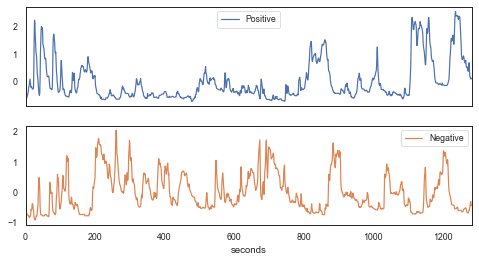

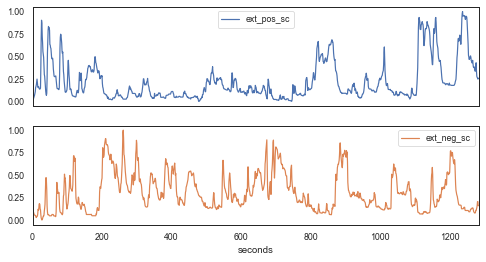

In [16]:
out_dir = '/Users/catcamacho/Box/CCP/EmoCodes_project/reliability_data/analysis/AHKJ/'

# load, average, and graph external ratings
ext_proc_dir = '/Users/catcamacho/Box/CCP/EmoCodes_project/reliability_data/UGTV_data_summary/'
ext_ratings = pd.read_csv(ext_proc_dir+'AHKJ_ratings.csv', index_col=None)
ext_ratings.index.name = 'seconds'

# rescale the values to match the internal scoring
mm = MinMaxScaler((0,1))
ext_ratings[['ext_pos_sc','ext_neg_sc']] = mm.fit_transform(ext_ratings[['Positive','Negative']])

# plot the scores
ext_ratings.plot(y=['Positive','Negative'], subplots=True, figsize=(8,4), xlim=(0,len(ext_ratings)))
ext_ratings.plot(y=['ext_pos_sc','ext_neg_sc'], subplots=True, figsize=(8,4), xlim=(0,len(ext_ratings)))

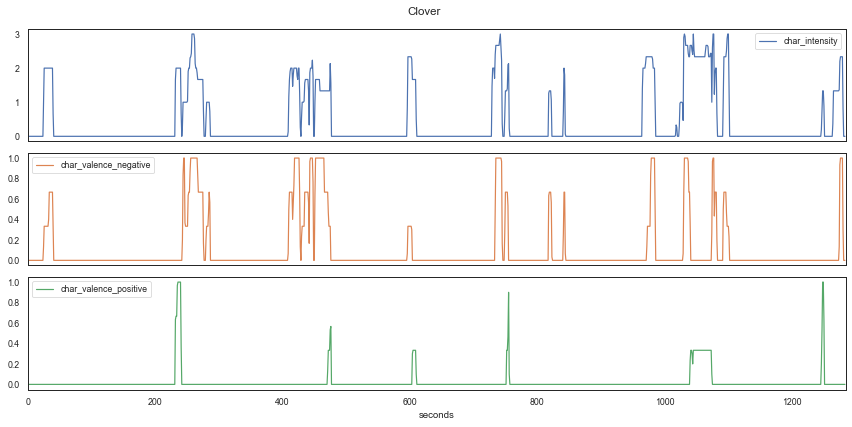

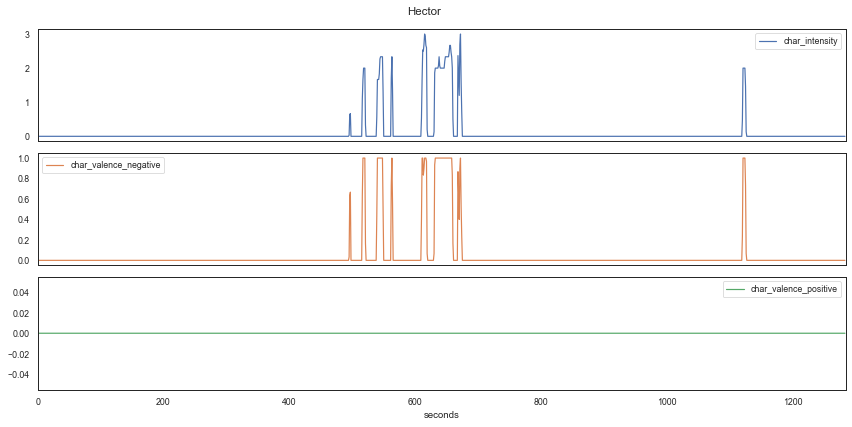

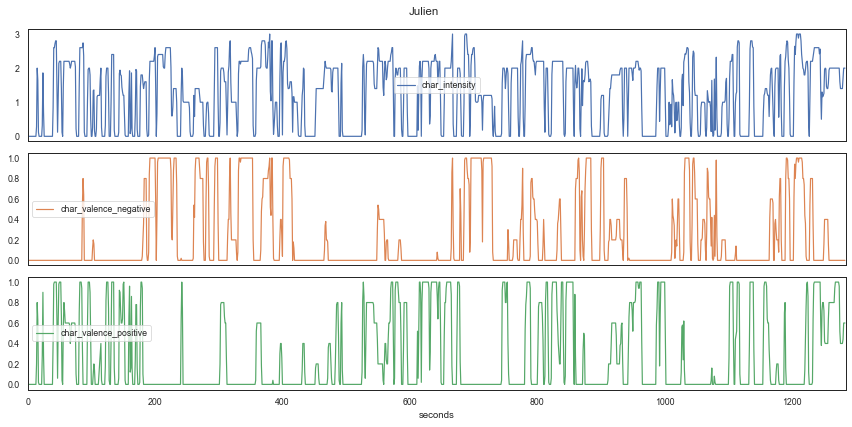

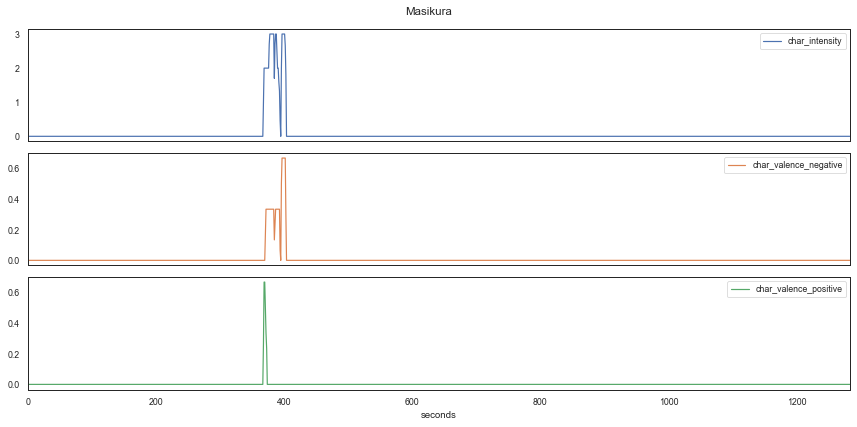

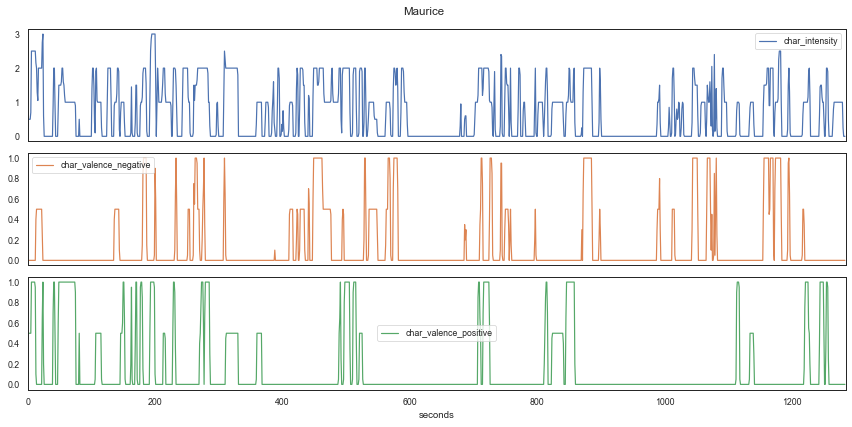

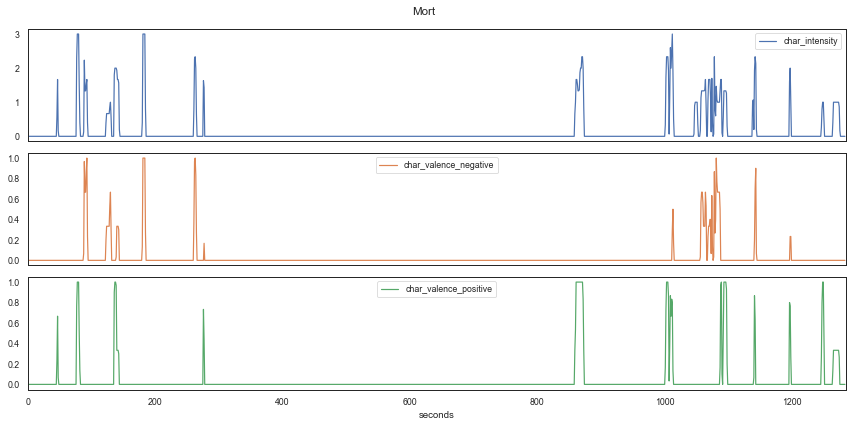

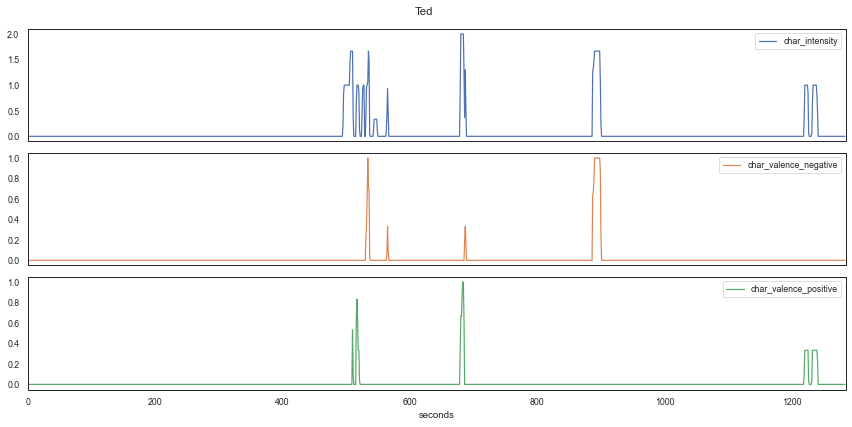

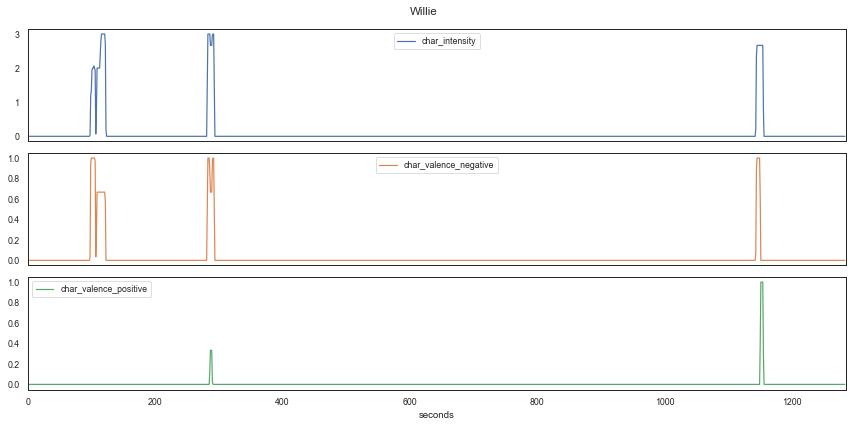

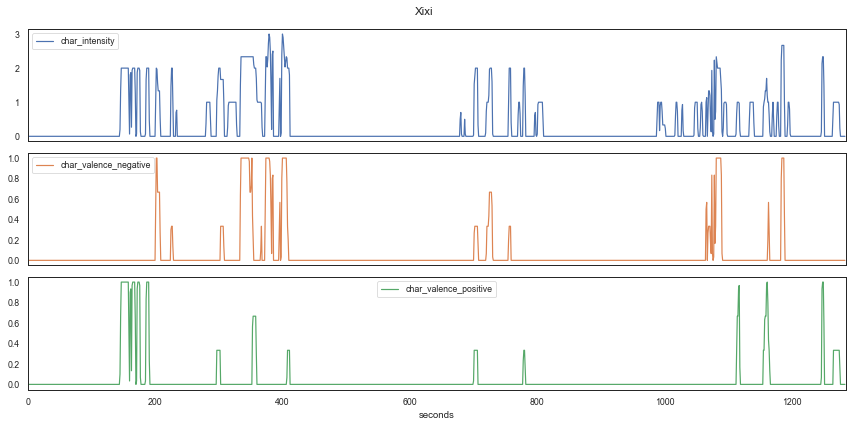

In [17]:
# load internal ratings and average across raters
int_proc_dir = '/Users/catcamacho/Box/CCP/EmoCodes_project/reliability_data/processed/AHKJ_S1E2/'
int_char_files = sorted(glob(int_proc_dir + '*subjective_character*'))
dfs = []

# load character data
for file in int_char_files:
    name_start = file.find('character_') + len('character_')
    name_end = file.find('_timeseries')
    char = file[name_start:name_end]
    rater = file[-22:-20]
    temp = pd.read_csv(file, index_col=None)
    if 'character_on_screen' in temp.columns:
        temp['on_screen'] = temp['character_on_screen']
        temp =temp.drop('character_on_screen', axis=1)
    if 'char_arousal' in temp.columns:
        temp['char_intensity'] = temp['char_arousal']
        temp=temp.drop('char_arousal', axis=1)
    temp['char_neg_int'] = temp['char_valence_negative']*temp['char_intensity']
    temp['char_pos_int'] = temp['char_valence_positive']*temp['char_intensity']
    t = temp['time']/1000
    temp[temp['on_screen']==0] = 0 # for character codes only
    tind = np.arange(0,1284,1)
    temp.index = pd.to_datetime(t,unit='s')
    temp.index.name = 'seconds'
    temp = temp.resample('1s').mean().round(1)
    temp.index = tind
    temp.index.name='seconds'
    temp['rater'] = rater
    temp['char_name'] = char
    dfs.append(temp)

chardata = pd.concat(dfs)

# plot each set of subjective ratings
for title, char in chardata.groupby('char_name'):
    char = char.groupby('seconds').mean()
    if title=='noncharacter':
        char.plot(y=['audio_intensity','audio_valence_negative','audio_valence_positive'],
                                   xlim=(0,1284), title=title, figsize=(12,6), subplots=True)
        plt.tight_layout()
        #plt.savefig(out_dir + 'subjcodes_{0}_audio.svg'.format(title))
        plt.show()
        plt.close()
        char.plot(y=['visual_degree','visual_valence_negative','visual_valence_positive'],
                                   xlim=(0,1284), title=title, figsize=(12,6), subplots=True)
        plt.tight_layout()
        #plt.savefig(out_dir + 'subjcodes_{0}_visual.svg'.format(title))
        plt.show()
        plt.close()
    else:
        char.plot(y=['char_intensity','char_valence_negative','char_valence_positive'],
                                   xlim=(0,1284), title=title, figsize=(12,6), subplots=True)
        plt.tight_layout()
        #plt.savefig(out_dir + 'subjcodes_char_{0}.svg'.format(title))
        plt.show()
        plt.close()

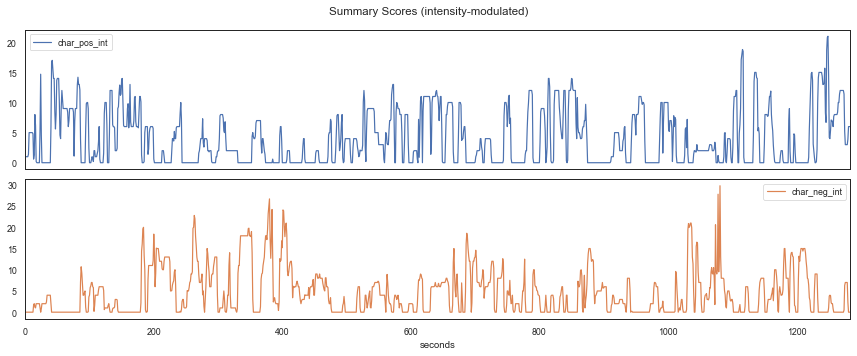

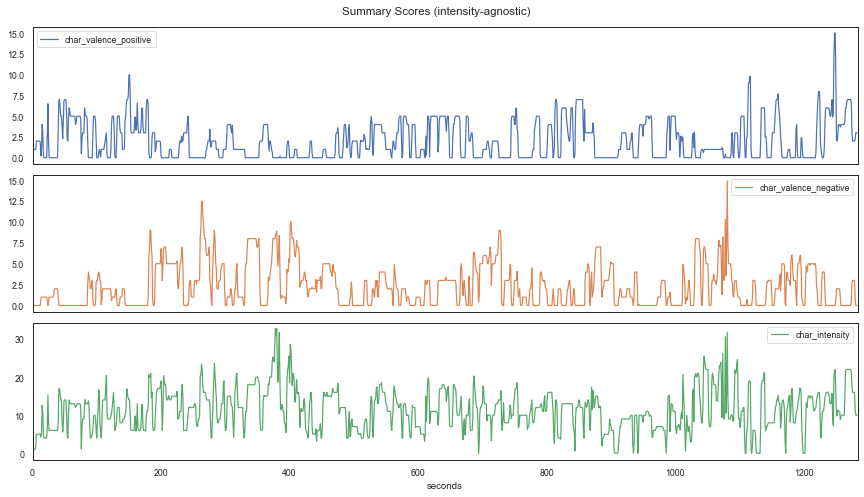

In [18]:
# summarize character codes
summary_data_sum = chardata.groupby('seconds').sum()

summary_codes = summary_data_sum.loc[:,['char_valence_negative','char_valence_positive','char_intensity','char_pos_int', 'char_neg_int']]

summary_codes.plot(y=['char_pos_int','char_neg_int'], xlim=(0,1284), title='Summary Scores (intensity-modulated)', figsize=(12,5), 
                   subplots=True)
plt.tight_layout()
plt.savefig(out_dir + 'char_posneg_imca.svg')
plt.show()
plt.close()
summary_codes.plot(y=['char_valence_positive','char_valence_negative','char_intensity'], xlim=(0,1284), title='Summary Scores (intensity-agnostic)', 
                   figsize=(12,7), subplots=True)
plt.tight_layout()
plt.savefig(out_dir + 'char_posnegint.svg')
plt.show()
plt.close()

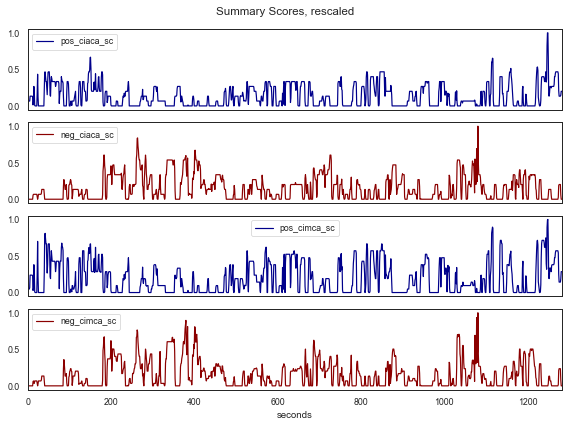

In [19]:
# pull out and rescale internal summary codes
int_ratings = summary_data_sum.loc[:,['char_valence_positive','char_valence_negative','char_pos_int','char_neg_int']]
int_ratings.loc[:,['pos_ciaca_sc','neg_ciaca_sc','pos_cimca_sc','neg_cimca_sc']] = mm.fit_transform(int_ratings[['char_valence_positive','char_valence_negative','char_pos_int','char_neg_int']])
int_ratings.plot(y=['pos_ciaca_sc','neg_ciaca_sc','pos_cimca_sc','neg_cimca_sc'], 
                 subplots=True, figsize=(8,6), xlim=(0,1284), title='Summary Scores, rescaled', color=['darkblue','darkred','darkblue','darkred'])
plt.tight_layout()
plt.show()

int_ratings.to_csv(out_dir + 'internal_summary_scores.csv')

#### 2. Do a side-by-side comparison of each summary score

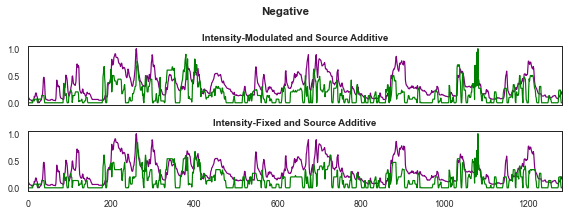

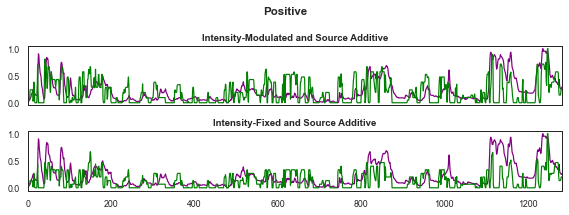

In [20]:
# combine internal and external ratings into a single dataframe
ratings = ext_ratings.merge(int_ratings, left_index=True, right_index=True)
ratings = ratings.drop(['rating_time', 'Positive', 'Negative','char_valence_positive','char_valence_negative','char_pos_int','char_neg_int'], axis=1)

# plot negative
fig, ax = plt.subplots(2,1, figsize=(8,3), sharex=True)
fig.suptitle('Negative', weight='bold')
plt.setp(ax, xlim=(0,1284))
ax[0].plot(ratings['ext_neg_sc'], color='purple')
ax[0].plot(ratings['neg_cimca_sc'], color='green')
ax[0].set_title('Intensity-Modulated and Source Additive', weight='bold')
ax[1].plot(ratings['ext_neg_sc'], color='purple')
ax[1].plot(ratings['neg_ciaca_sc'], color='green')
ax[1].set_title('Intensity-Fixed and Source Additive', weight='bold')
plt.tight_layout()
plt.savefig(out_dir + 'internal-external_overlays_negative.svg')
plt.show()
plt.close()

# plot positive
fig, ax = plt.subplots(2,1, figsize=(8,3), sharex=True)
fig.suptitle('Positive', weight='bold')
plt.setp(ax, xlim=(0,1284))
ax[0].plot(ratings['ext_pos_sc'], color='purple')
ax[0].plot(ratings['pos_cimca_sc'], color='green')
ax[0].set_title('Intensity-Modulated and Source Additive', weight='bold')
ax[1].plot(ratings['ext_pos_sc'], color='purple')
ax[1].plot(ratings['pos_ciaca_sc'], color='green')
ax[1].set_title('Intensity-Fixed and Source Additive', weight='bold')
plt.tight_layout()
plt.savefig(out_dir + 'internal-external_overlays_positive.svg')
plt.show()
plt.close()

#### 3. Compute similarity between each metric

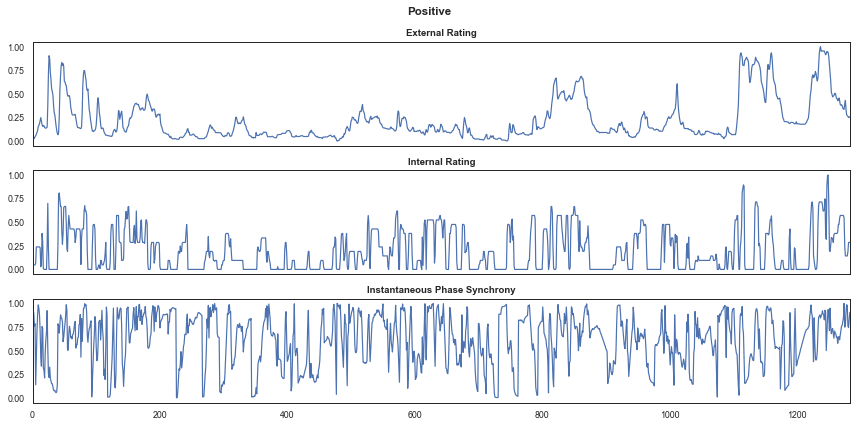

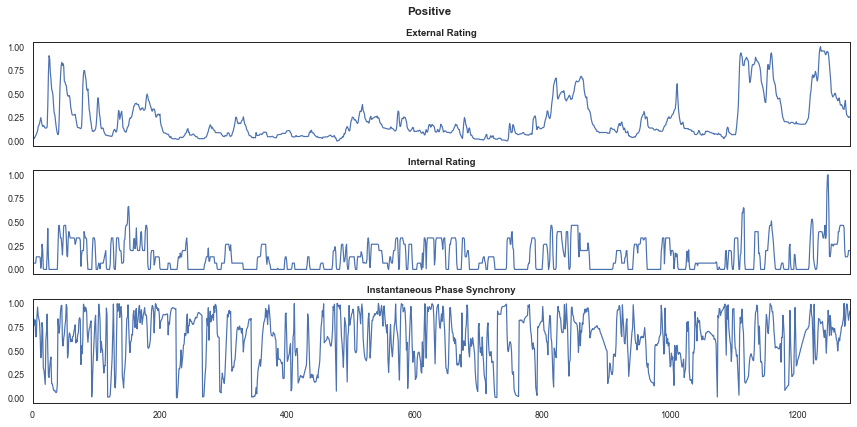

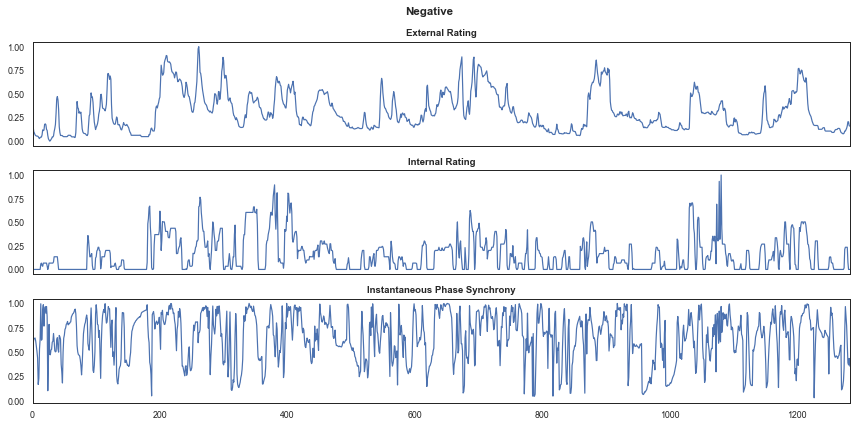

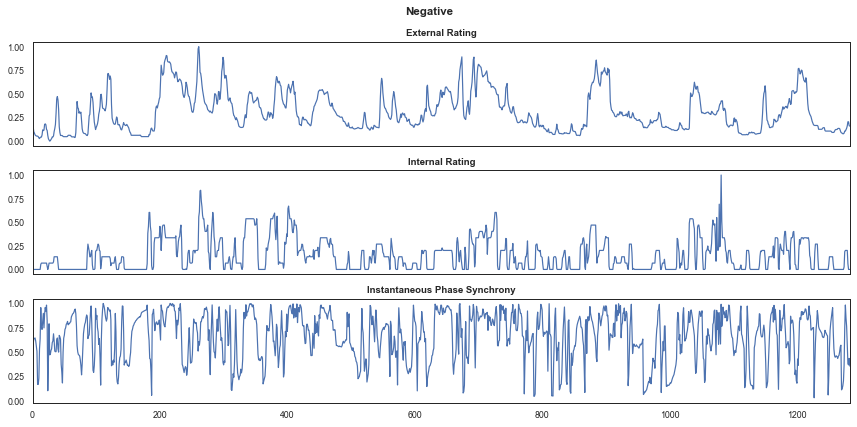

In [7]:
from scipy.signal import hilbert
from scipy.stats import spearmanr

# computer instantaneous phase synchrony
ips = pd.DataFrame(columns=['extpossc_meanIPS', 'extnegsc_meanIPS'])

for a in ['pos_cimca_sc','pos_ciaca_sc']:
    aphase = np.angle(hilbert(ratings['ext_pos_sc']),deg=False)
    bphase = np.angle(hilbert(ratings[a]),deg=False)
    phase_synchrony = 1-np.sin(np.abs(aphase-bphase)/2)
    ips.loc[a,'extpossc_meanIPS'] = np.mean(phase_synchrony)
    fig, ax = plt.subplots(3,1, figsize=(12,6), sharex=True)
    fig.suptitle('Positive', weight='bold')
    plt.setp(ax, xlim=(0,1284))
    ax[0].plot(ratings['ext_pos_sc'])
    ax[0].set_title('External Rating', weight='bold')
    ax[1].plot(ratings[a])
    ax[1].set_title('Internal Rating', weight='bold')
    ax[2].plot(phase_synchrony)
    ax[2].set_title('Instantaneous Phase Synchrony', weight='bold')
    plt.tight_layout()
    plt.savefig(out_dir + 'IPS_Negative_ext_{0}.svg'.format(a))
    plt.show()

for a in ['neg_cimca_sc','neg_ciaca_sc']:
    aphase = np.angle(hilbert(ratings['ext_neg_sc']),deg=False)
    bphase = np.angle(hilbert(ratings[a]),deg=False)
    phase_synchrony = 1-np.sin(np.abs(aphase-bphase)/2)
    ips.loc[a,'extnegsc_meanIPS'] = np.mean(phase_synchrony)
    fig, ax = plt.subplots(3,1, figsize=(12,6), sharex=True)
    fig.suptitle('Negative', weight='bold')
    plt.setp(ax, xlim=(0,1284))
    ax[0].plot(ratings['ext_neg_sc'])
    ax[0].set_title('External Rating', weight='bold')
    ax[1].plot(ratings[a])
    ax[1].set_title('Internal Rating', weight='bold')
    ax[2].plot(phase_synchrony)
    ax[2].set_title('Instantaneous Phase Synchrony', weight='bold')
    plt.tight_layout()
    plt.savefig(out_dir + 'IPS_Negative_ext_{0}.svg'.format(a))
    plt.show()
    
ips.to_csv(out_dir + 'IPS_int_ext.csv')

# compute correlation coefficient
corrspear = pd.DataFrame(columns=['ext_pos_sc', 'ext_neg_sc'])

for a in ['pos_cimca_sc','pos_ciaca_sc']:
    r, p = spearmanr(ratings['ext_pos_sc'], ratings[a])
    corrspear.loc[a, 'ext_pos_sc'] = r
    
for a in ['neg_cimca_sc','neg_ciaca_sc']:
    r, p = spearmanr(ratings['ext_neg_sc'], ratings[a])
    corrspear.loc[a, 'ext_neg_sc'] = r   
    
corrspear.to_csv(out_dir + 'spearman_corr_int_ext.csv')

## MLP

#### 1. Load each external and internal ratings
Load and averal external affective ratings, load and average internal affective ratings, and compute global positive and negative scores from internal ratings

array([<AxesSubplot:xlabel='seconds'>, <AxesSubplot:xlabel='seconds'>],
      dtype=object)

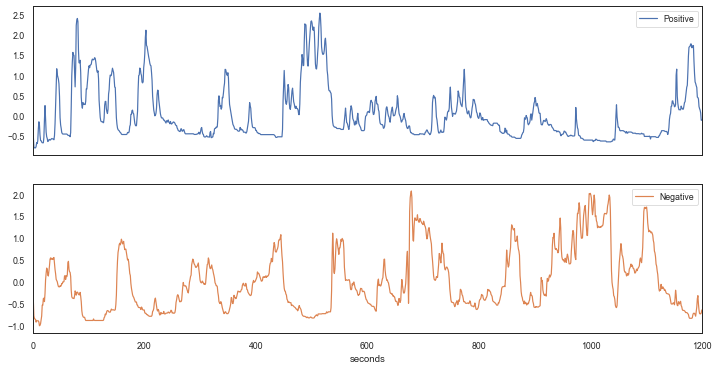

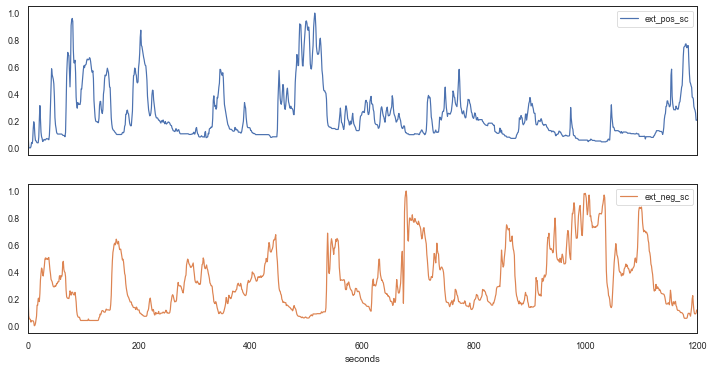

In [8]:
out_dir = '/Users/catcamacho/Box/CCP/EmoCodes_project/reliability_data/analysis/MLP/'

# load, average, and graph external ratings
ext_proc_dir = '/Users/catcamacho/Box/CCP/EmoCodes_project/reliability_data/UGTV_data_summary/'
ext_ratings = pd.read_csv(ext_proc_dir+'MLP_ratings.csv', index_col=None)
ext_ratings.index.name = 'seconds'

# rescale the values to match the internal scoring
mm = MinMaxScaler((0,1))
ext_ratings[['ext_pos_sc','ext_neg_sc']] = mm.fit_transform(ext_ratings[['Positive','Negative']])

# plot the scores
ext_ratings.plot(y=['Positive','Negative'], subplots=True, figsize=(12,6), xlim=(0,len(ext_ratings)))
ext_ratings.plot(y=['ext_pos_sc','ext_neg_sc'], subplots=True, figsize=(12,6), xlim=(0,len(ext_ratings)))

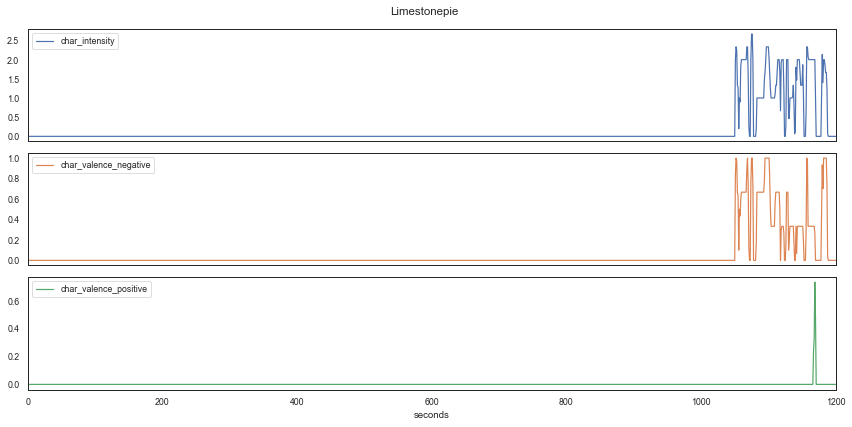

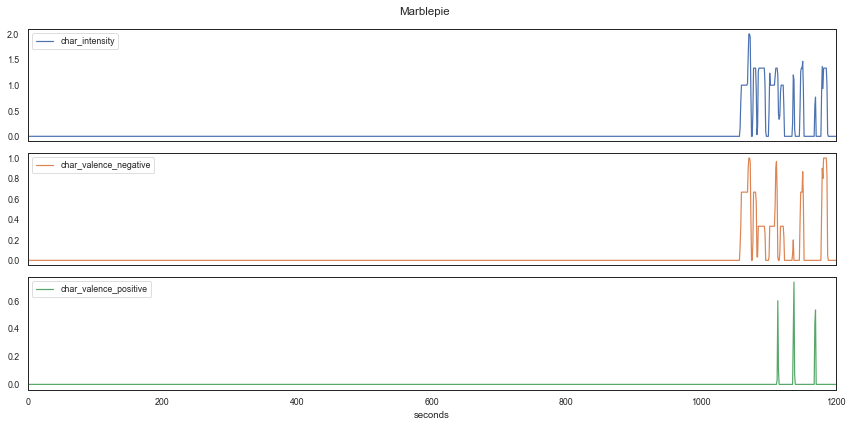

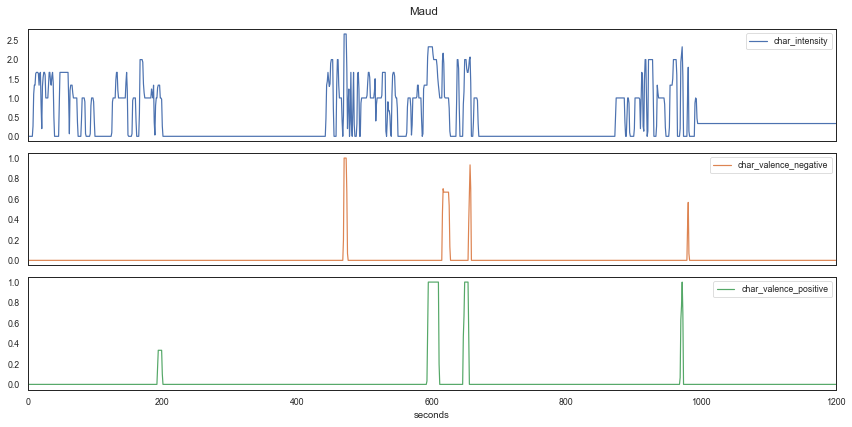

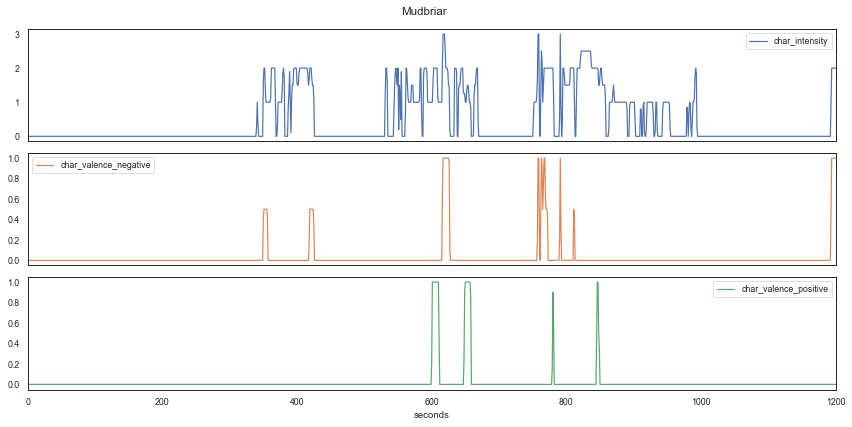

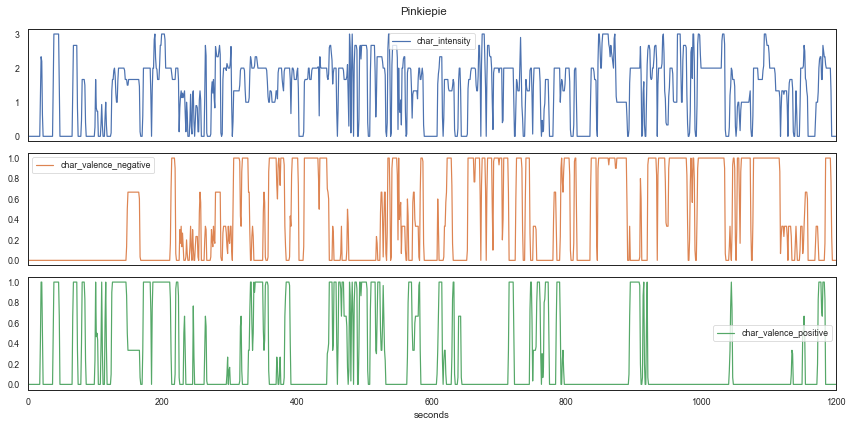

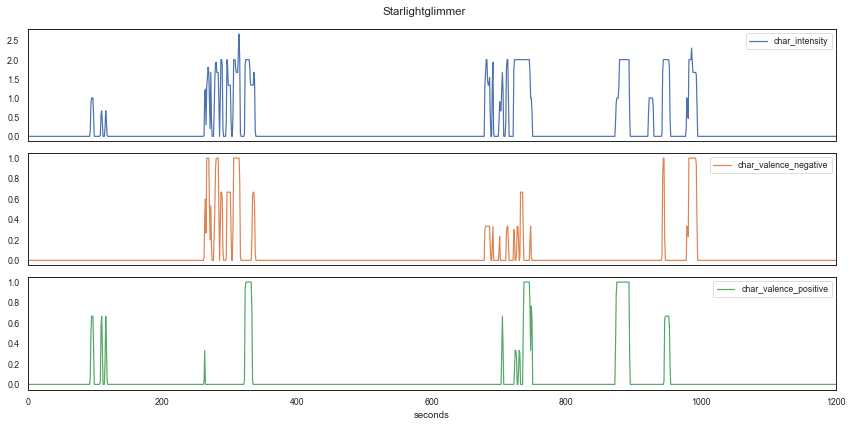

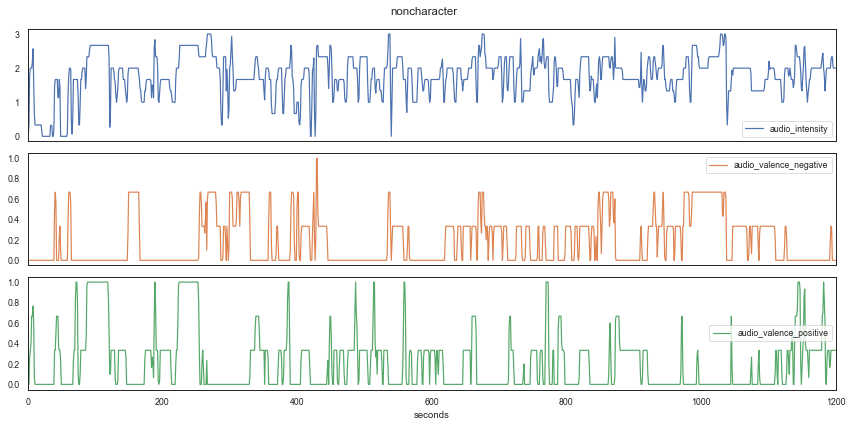

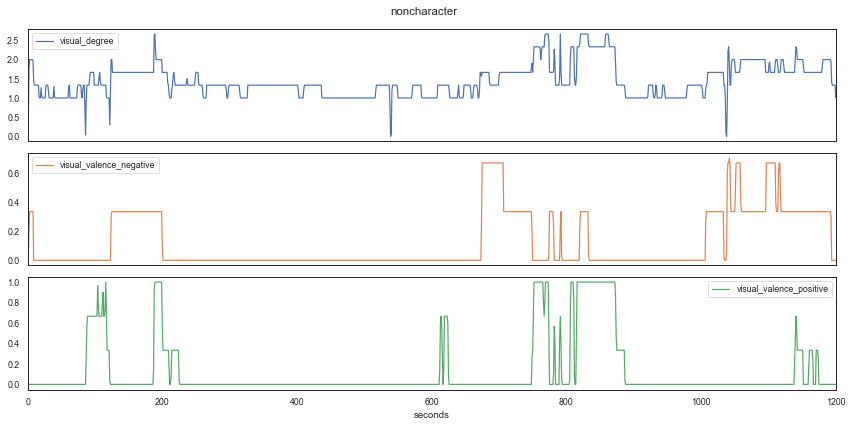

In [9]:
# load internal ratings and average across raters
int_proc_dir = '/Users/catcamacho/Box/CCP/EmoCodes_project/reliability_data/processed/MLP_S8E3/'
int_char_files = sorted(glob(int_proc_dir + '*subjective_character*'))
int_nonchar_files = sorted(glob(int_proc_dir + '*nonchar*'))
dfs = []

# load character data
for file in int_char_files:
    name_start = file.find('character_') + len('character_')
    name_end = file.find('_timeseries')
    char = file[name_start:name_end]
    rater = file[-22:-20]
    temp = pd.read_csv(file, index_col=None)
    if 'character_on_screen' in temp.columns:
        temp['on_screen'] = temp['character_on_screen']
        temp =temp.drop('character_on_screen', axis=1)
    if 'char_arousal' in temp.columns:
        temp['char_intensity'] = temp['char_arousal']
        temp=temp.drop('char_arousal', axis=1)
    temp['char_neg_int'] = temp['char_valence_negative']*temp['char_intensity']
    temp['char_pos_int'] = temp['char_valence_positive']*temp['char_intensity']
    t = temp['time']/1000
    temp[temp['on_screen']==0] = 0 # for character codes only
    tind = np.arange(0,1201,1)
    temp.index = pd.to_datetime(t,unit='s')
    temp.index.name = 'seconds'
    temp = temp.resample('1s').mean().round(1)
    temp.index = tind
    temp.index.name='seconds'
    temp['rater'] = rater
    temp['char_name'] = char
    dfs.append(temp)

# load non-character subjective data
for file in int_nonchar_files:
    rater = file[-22:-20]
    temp = pd.read_csv(file, index_col=None)
    temp['audio_neg_int'] = temp['audio_valence_negative']*temp['audio_intensity']
    temp['audio_pos_int'] = temp['audio_valence_positive']*temp['audio_intensity']
    if 'visual_valence_negative' in temp.columns:
        temp['visual_neg_int'] = temp['visual_valence_negative']*temp['visual_degree']
        temp['visual_pos_int'] = temp['visual_valence_positive']*temp['visual_degree']
    t = temp['time']/1000
    tind = np.arange(0,1201,1)
    temp.index = pd.to_datetime(t,unit='s', origin=0)
    temp.index.name = 'seconds'
    temp = temp.resample('1s').mean().round(1)
    temp.index = tind
    temp.index.name='seconds'
    temp['rater'] = rater
    temp['char_name'] = 'noncharacter'
    dfs.append(temp)

chardata = pd.concat(dfs)

# plot each set of subjective ratings
for title, char in chardata.groupby('char_name'):
    char = char.groupby('seconds').mean()
    if title=='noncharacter':
        char.plot(y=['audio_intensity','audio_valence_negative','audio_valence_positive'],
                                   xlim=(0,1201), title=title, figsize=(12,6), subplots=True)
        plt.tight_layout()
        plt.savefig(out_dir + 'subjcodes_{0}_audio.svg'.format(title))
        plt.show()
        plt.close()
        char.plot(y=['visual_degree','visual_valence_negative','visual_valence_positive'],
                                   xlim=(0,1201), title=title, figsize=(12,6), subplots=True)
        plt.tight_layout()
        plt.savefig(out_dir + 'subjcodes_{0}_visual.svg'.format(title))
        plt.show()
        plt.close()
    else:
        char.plot(y=['char_intensity','char_valence_negative','char_valence_positive'],
                                   xlim=(0,1201), title=title, figsize=(12,6), subplots=True)
        plt.tight_layout()
        plt.savefig(out_dir + 'subjcodes_char_{0}.svg'.format(title))
        plt.show()
        plt.close()

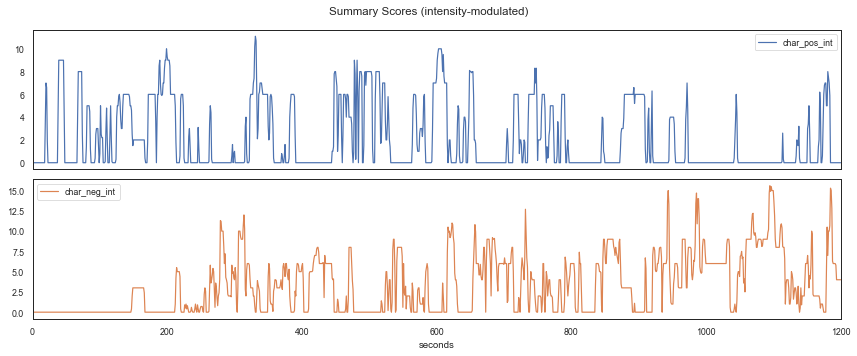

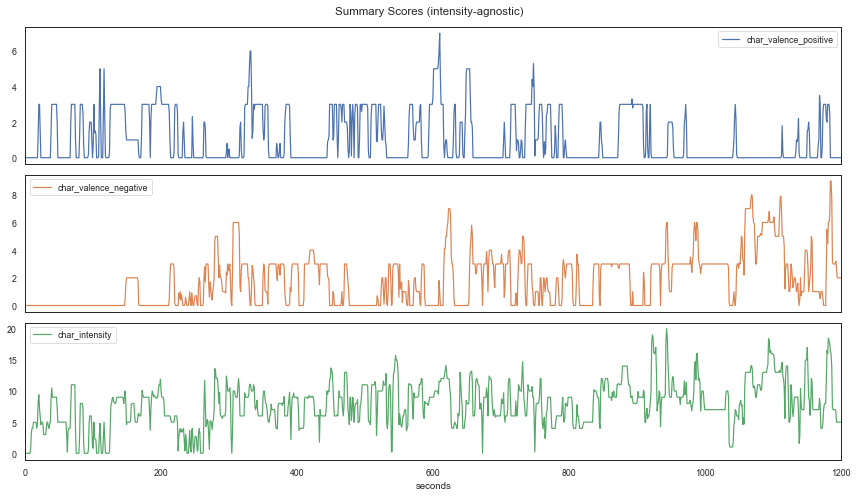

In [10]:
# summarize data in 3 ways
summary_data_sum = chardata.groupby('seconds').sum()

summary_codes = summary_data_sum.loc[:,['audio_intensity', 'audio_valence_negative', 'audio_valence_positive','visual_degree', 
                                        'visual_valence_negative','visual_valence_positive', 'audio_neg_int', 'audio_pos_int',
                                        'visual_neg_int', 'visual_pos_int']]
summary_codes.loc[:,['char_negative_sum','char_positive_sum','char_intensity_sum','char_posint_sum',
                  'char_negint_sum']] = summary_data_sum.loc[:,['char_valence_negative','char_valence_positive','char_intensity',
                                                             'char_pos_int', 'char_neg_int']]

summary_codes['pos_imca'] = summary_codes[['char_posint_sum','audio_pos_int','visual_pos_int']].sum(axis=1)
summary_codes['neg_imca'] = summary_codes[['char_negint_sum','audio_neg_int','visual_neg_int']].sum(axis=1)

# intensity agnostic, character additive
summary_codes['pos_iaca'] = summary_codes[['char_positive_sum','audio_valence_positive','visual_valence_positive']].sum(axis=1)
summary_codes['neg_iaca'] = summary_codes[['char_negative_sum','audio_valence_negative','visual_valence_negative']].sum(axis=1)
summary_codes['global_intensity'] = summary_codes[['char_intensity_sum','visual_degree','audio_intensity']].sum(axis=1)

summary_data_sum.plot(y=['char_pos_int','char_neg_int'], xlim=(0,1201), title='Summary Scores (intensity-modulated)', figsize=(12,5), 
                   subplots=True)
plt.tight_layout()
plt.savefig(out_dir + 'char_posneg_imca.svg')
plt.show()
plt.close()
summary_data_sum.plot(y=['char_valence_positive','char_valence_negative','char_intensity'], xlim=(0,1201), title='Summary Scores (intensity-agnostic)', 
                   figsize=(12,7), subplots=True)
plt.tight_layout()
plt.savefig(out_dir + 'char_posnegint.svg')
plt.show()
plt.close()

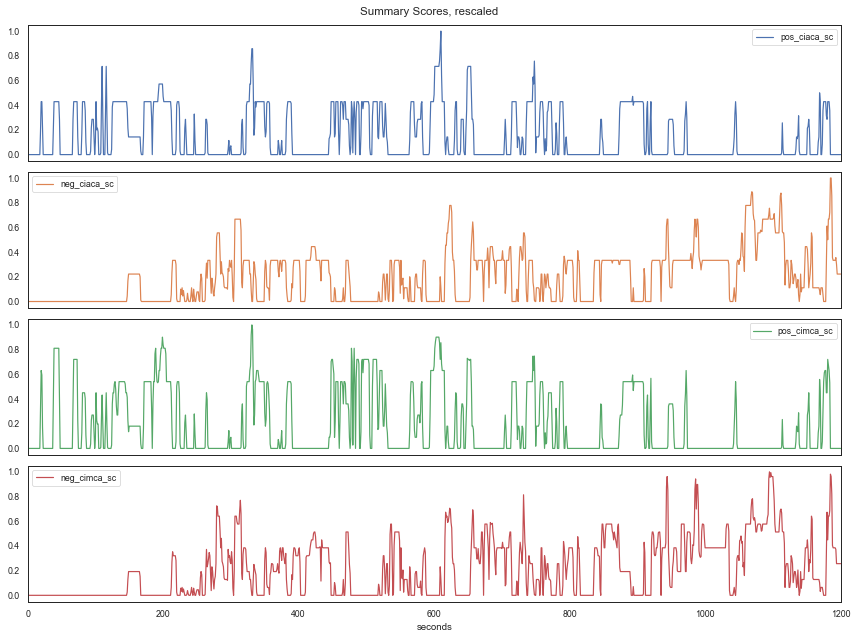

In [11]:
# pull out and rescale internal summary codes
int_ratings = summary_data_sum.loc[:,['char_valence_positive','char_valence_negative','char_pos_int','char_neg_int']]
int_ratings.loc[:,['pos_ciaca_sc','neg_ciaca_sc',
                   'pos_cimca_sc','neg_cimca_sc']] = mm.fit_transform(int_ratings[['char_valence_positive',
                                                                                   'char_valence_negative',
                                                                                   'char_pos_int','char_neg_int']])
int_ratings.plot(y=['pos_ciaca_sc','neg_ciaca_sc','pos_cimca_sc','neg_cimca_sc'], 
                 subplots=True, figsize=(12,9), xlim=(0,1201), title='Summary Scores, rescaled')
plt.tight_layout()
plt.show()

int_ratings.to_csv(out_dir + 'internal_summary_scores.csv')

#### 2. Do a side-by-side comparison of each summary score

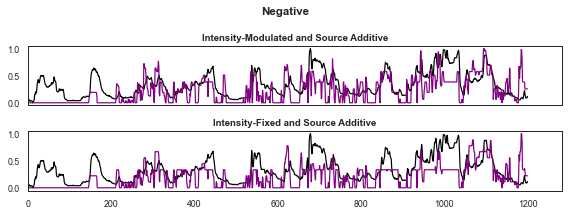

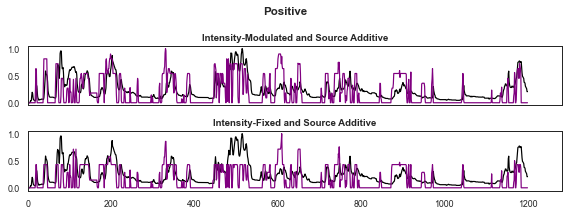

In [12]:
# combine internal and external ratings into a single dataframe
ratings = ext_ratings.merge(int_ratings, left_index=True, right_index=True)
ratings = ratings.drop(['rating_time', 'Positive', 'Negative','char_valence_positive','char_valence_negative','char_pos_int','char_neg_int'], axis=1)

# plot negative
fig, ax = plt.subplots(2,1, figsize=(8,3), sharex=True)
fig.suptitle('Negative', weight='bold')
plt.setp(ax, xlim=(0,1284))
ax[0].plot(ratings['ext_neg_sc'], color='black')
ax[0].plot(ratings['neg_cimca_sc'], color='purple')
ax[0].set_title('Intensity-Modulated and Source Additive', weight='bold')
ax[1].plot(ratings['ext_neg_sc'], color='black')
ax[1].plot(ratings['neg_ciaca_sc'], color='purple')
ax[1].set_title('Intensity-Fixed and Source Additive', weight='bold')
plt.tight_layout()
plt.savefig(out_dir + 'internal-external_overlays_negative.svg')
plt.show()
plt.close()

# plot positive
fig, ax = plt.subplots(2,1, figsize=(8,3), sharex=True)
fig.suptitle('Positive', weight='bold')
plt.setp(ax, xlim=(0,1284))
ax[0].plot(ratings['ext_pos_sc'], color='black')
ax[0].plot(ratings['pos_cimca_sc'], color='purple')
ax[0].set_title('Intensity-Modulated and Source Additive', weight='bold')
ax[1].plot(ratings['ext_pos_sc'], color='black')
ax[1].plot(ratings['pos_ciaca_sc'], color='purple')
ax[1].set_title('Intensity-Fixed and Source Additive', weight='bold')
plt.tight_layout()
plt.savefig(out_dir + 'internal-external_overlays_positive.svg')
plt.show()
plt.close()

#### 3. Compute similarity between each metric

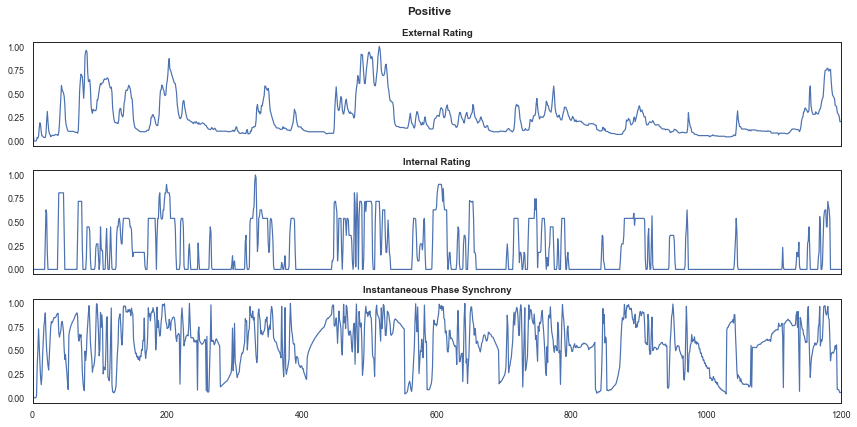

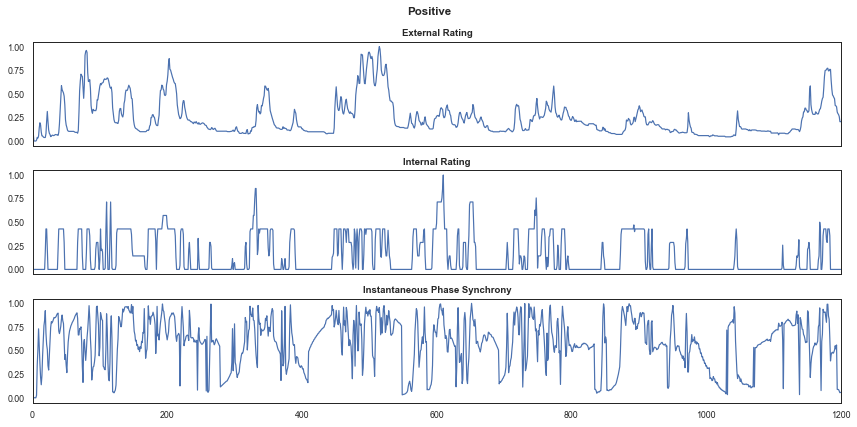

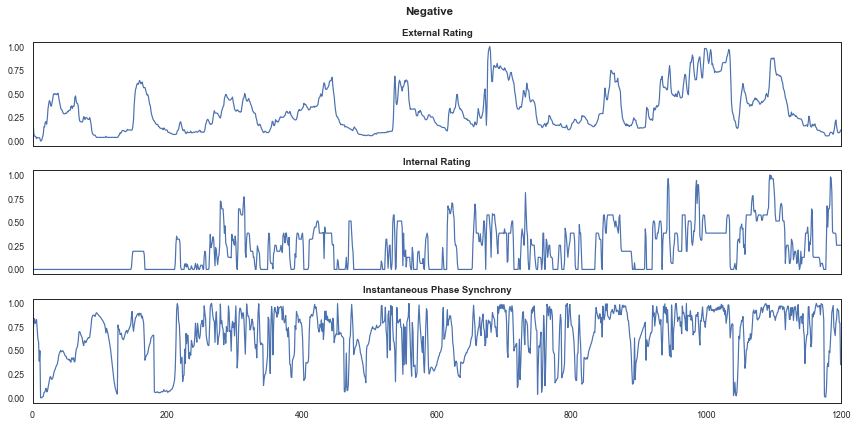

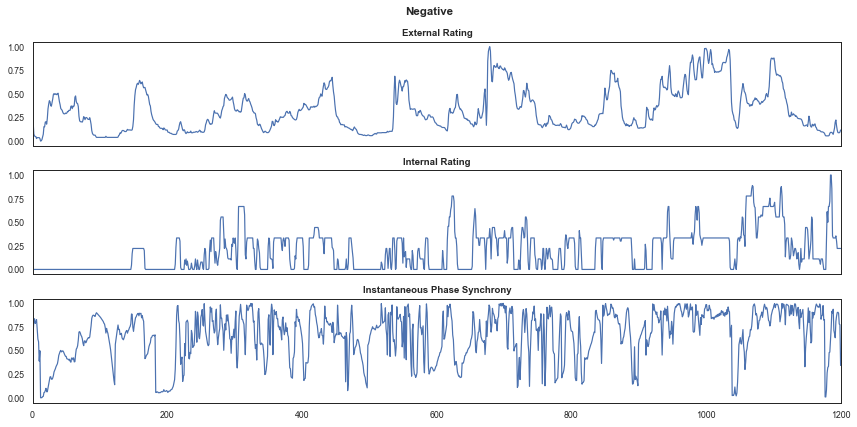

In [13]:
from scipy.signal import hilbert
from scipy.stats import spearmanr

# computer instantaneous phase synchrony
ips = pd.DataFrame(columns=['extpossc_meanIPS', 'extnegsc_meanIPS'])

for a in ['pos_cimca_sc','pos_ciaca_sc']:
    aphase = np.angle(hilbert(ratings['ext_pos_sc']),deg=False)
    bphase = np.angle(hilbert(ratings[a]),deg=False)
    phase_synchrony = 1-np.sin(np.abs(aphase-bphase)/2)
    ips.loc[a,'extpossc_meanIPS'] = np.mean(phase_synchrony)
    fig, ax = plt.subplots(3,1, figsize=(12,6), sharex=True)
    fig.suptitle('Positive', weight='bold')
    plt.setp(ax, xlim=(0,1201))
    ax[0].plot(ratings['ext_pos_sc'])
    ax[0].set_title('External Rating', weight='bold')
    ax[1].plot(ratings[a])
    ax[1].set_title('Internal Rating', weight='bold')
    ax[2].plot(phase_synchrony)
    ax[2].set_title('Instantaneous Phase Synchrony', weight='bold')
    plt.tight_layout()
    plt.savefig(out_dir + 'IPS_Negative_ext_{0}.svg'.format(a))
    plt.show()

for a in ['neg_cimca_sc','neg_ciaca_sc']:
    aphase = np.angle(hilbert(ratings['ext_neg_sc']),deg=False)
    bphase = np.angle(hilbert(ratings[a]),deg=False)
    phase_synchrony = 1-np.sin(np.abs(aphase-bphase)/2)
    ips.loc[a,'extnegsc_meanIPS'] = np.mean(phase_synchrony)
    fig, ax = plt.subplots(3,1, figsize=(12,6), sharex=True)
    fig.suptitle('Negative', weight='bold')
    plt.setp(ax, xlim=(0,1201))
    ax[0].plot(ratings['ext_neg_sc'])
    ax[0].set_title('External Rating', weight='bold')
    ax[1].plot(ratings[a])
    ax[1].set_title('Internal Rating', weight='bold')
    ax[2].plot(phase_synchrony)
    ax[2].set_title('Instantaneous Phase Synchrony', weight='bold')
    plt.tight_layout()
    plt.savefig(out_dir + 'IPS_Negative_ext_{0}.svg'.format(a))
    plt.show()
    
ips.to_csv(out_dir + 'IPS_int_ext.csv')

# compute correlation coefficient
corrspear = pd.DataFrame(columns=['ext_pos_sc', 'ext_neg_sc'])

for a in ['pos_cimca_sc','pos_ciaca_sc']:
    r, p = spearmanr(ratings['ext_pos_sc'], ratings[a])
    corrspear.loc[a, 'ext_pos_sc'] = r
    
for a in ['neg_cimca_sc','neg_ciaca_sc']:
    r, p = spearmanr(ratings['ext_neg_sc'], ratings[a])
    corrspear.loc[a, 'ext_neg_sc'] = r   
    
corrspear.to_csv(out_dir + 'spearman_corr_int_ext.csv')